## Импорт бибилиотек и функции

In [57]:
# импорт нужных бибилиотек
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='Greens', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")

  print(f'accuracy_score:\t\t{model_accuracy:.4f}')
  print(f'precision_score:\t{model_precision:.4f}')
  print(f'recall_score:\t\t{model_recall:.4f}')
  print(f'f1_score:\t\t{model_f1:.4f}')

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'f1_score': model_f1,
  }

  return preformance_scores

## Загрузка набора данных

In [2]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 12 02:59 kaggle.json


In [4]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ichhadhari/indian-birds

100% 5.29G/5.30G [01:05<00:00, 133MB/s]
100% 5.30G/5.30G [01:05<00:00, 86.6MB/s]


## Чтение данных

In [7]:
# разархивирование данных
!unzip "/content/indian-birds.zip" -d "/content/birds"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_162.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_167.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_168.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_17.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_171.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_176.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_177.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_182.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_184.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_189.jpg  
  inflating: /content/birds/Birds_25/valid/Forest-Wagtail/Forest-Wagtail_204.jpg  
  inflating: /conten

In [8]:
# определение путей до папок с изображениями
dataset = {
             "train_data" : "/content/birds/Birds_25/train",
             "valid_data" : "/content/birds/Birds_25/valid",
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)
    print(category)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()

['Common-Myna', 'Common-Rosefinch', 'Red-Wattled-Lapwing', 'Forest-Wagtail', 'Hoopoe', 'White-Wagtail', 'Gray-Wagtail', 'White-Breasted-Waterhen', 'Ruddy-Shelduck', 'Sarus-Crane', 'Indian-Peacock', 'Coppersmith-Barbet', 'Northern-Lapwing', 'Indian-Pitta', 'Common-Kingfisher', 'White-Breasted-Kingfisher', 'House-Crow', 'Indian-Roller', 'Cattle-Egret', 'Asian-Green-Bee-Eater', 'Rufous-Treepie', 'Common-Tailorbird', 'Jungle-Babbler', 'Indian-Grey-Hornbill', 'Brown-Headed-Barbet']
['Common-Myna', 'Common-Rosefinch', 'Red-Wattled-Lapwing', 'Forest-Wagtail', 'Hoopoe', 'White-Wagtail', 'Gray-Wagtail', 'White-Breasted-Waterhen', 'Ruddy-Shelduck', 'Sarus-Crane', 'Indian-Peacock', 'Coppersmith-Barbet', 'Northern-Lapwing', 'Indian-Pitta', 'Common-Kingfisher', 'White-Breasted-Kingfisher', 'House-Crow', 'Indian-Roller', 'Cattle-Egret', 'Asian-Green-Bee-Eater', 'Rufous-Treepie', 'Common-Tailorbird', 'Jungle-Babbler', 'Indian-Grey-Hornbill', 'Brown-Headed-Barbet']


## Исследование данных

In [9]:
# создание набора данных для тренировки и валидации
train_df = pd.DataFrame(all_data[0], index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1], index=range(len(all_data[1]['imgpath'])))

In [10]:
train_df

,imgpath,labels
0,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna
1,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna
2,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna
3,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna
4,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna
...,...,...
29995,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet
29996,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet
29997,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet
29998,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet


In [11]:
# конвертируем названия классов в метки
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

class_names = lb.classes_

In [12]:
train_df

,imgpath,labels,encoded_labels
0,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna,4
1,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna,4
2,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna,4
3,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna,4
4,/content/birds/Birds_25/train/Common-Myna/Comm...,Common-Myna,4
...,...,...,...
29995,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet,1
29996,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet,1
29997,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet,1
29998,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet,1


In [13]:
# делим валидационную выборку на тестовую и валидационную
valid_df , test_df = train_test_split(valid_df, train_size= 0.95, shuffle=True, random_state=42)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [14]:
print(f"Размер тренировочной выборки: {train_df.shape[0]}")
print(f"Размер валидационной выборки: {valid_df.shape[0]}")
print(f"Размер тестовой выборки: {test_df.shape[0]}")

Размер тренировочной выборки: 30000
Размер валидационной выборки: 7125
Размер тестовой выборки: 375


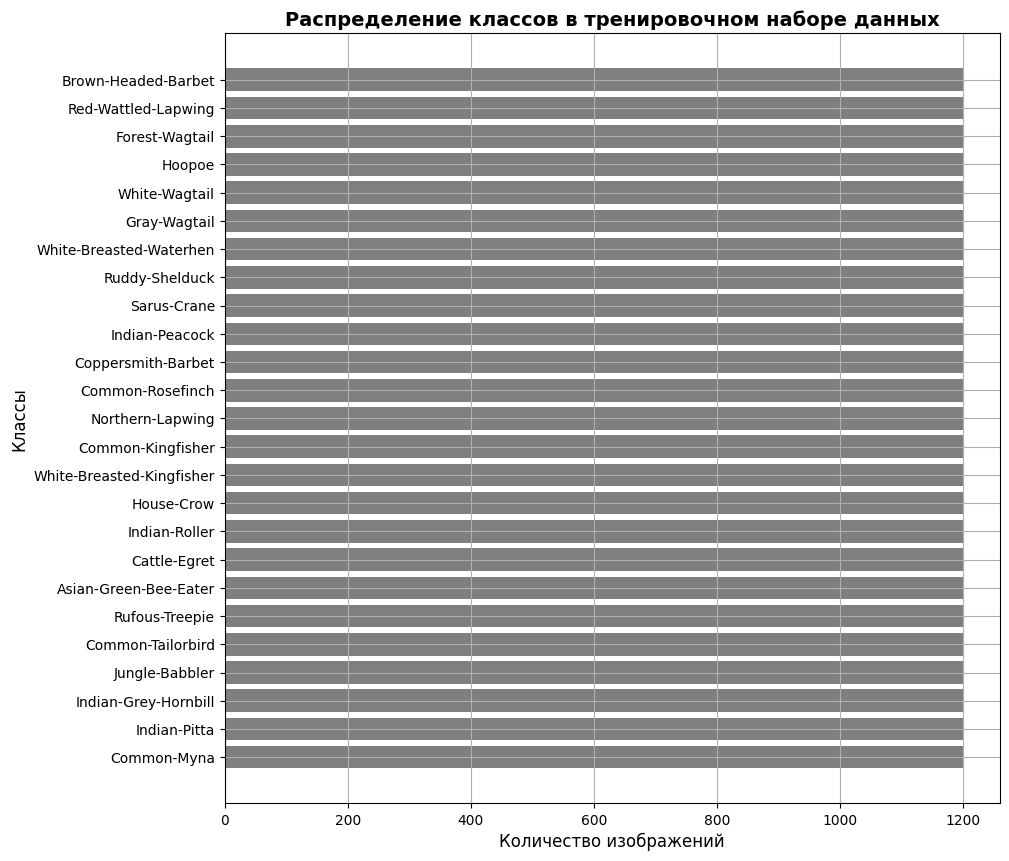

In [15]:
# количество изображений в тренировочной выборке на каждй класс
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.figure(figsize=(10, 10))
plt.title("Распределение классов в тренировочном наборе данных", fontsize=14, fontweight="bold")
plt.xlabel("Количество изображений", fontsize=12)
plt.ylabel("Классы", fontsize=12)
plt.barh(index, label, color="#7f7f7f")
plt.grid(True)
plt.show()

Количество изображений в каждом класе одинаково следовательно данные сбалансированы

In [16]:
# соответствие метки каждому классу
train_df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
10747,/content/birds/Birds_25/train/Ruddy-Shelduck/R...,Ruddy-Shelduck,19
12573,/content/birds/Birds_25/train/Indian-Peacock/I...,Indian-Peacock,13
29676,/content/birds/Birds_25/train/Brown-Headed-Bar...,Brown-Headed-Barbet,1
8856,/content/birds/Birds_25/train/White-Breasted-W...,White-Breasted-Waterhen,23
21098,/content/birds/Birds_25/train/Indian-Roller/In...,Indian-Roller,15
17458,/content/birds/Birds_25/train/Common-Kingfishe...,Common-Kingfisher,3
1476,/content/birds/Birds_25/train/Common-Rosefinch...,Common-Rosefinch,5
5120,/content/birds/Birds_25/train/Hoopoe/Hoopoe_22...,Hoopoe,10
18338,/content/birds/Birds_25/train/White-Breasted-K...,White-Breasted-Kingfisher,22
28279,/content/birds/Birds_25/train/Indian-Grey-Horn...,Indian-Grey-Hornbill,12


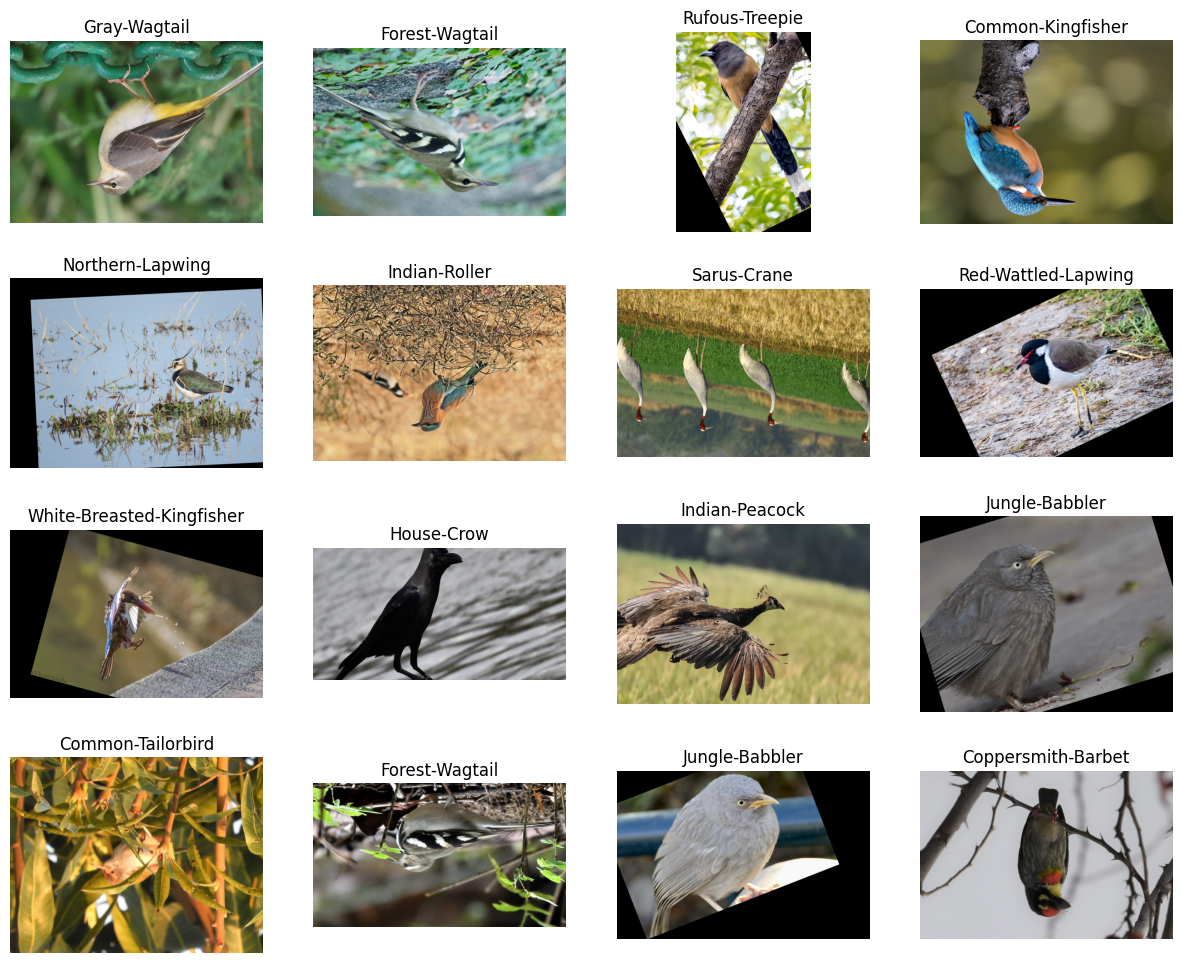

In [17]:
# визуализация набора данных
plt.figure(figsize=(15, 12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4, 4, i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')

## Создание наборов данных

In [18]:
# стандартизация наборов данных (указание размера изображения и формат)
BATCH_SIZE = 50
IMAGE_SIZE = (180, 180)


generator = ImageDataGenerator(
    preprocessing_function = keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 30000 validated image filenames belonging to 25 classes.
Found 7125 validated image filenames belonging to 25 classes.
Found 375 validated image filenames belonging to 25 classes.


## Обучение моделей

### Первая модель

In [20]:
import tensorflow as tf

In [21]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


In [22]:
# создаем модель нейронной сети
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)), # объявляем размер входных данных
    layers.Rescaling(1./255), # нормализуем данные (делим на 255 чтобы все значения были в диапазоне от 0 до 1)
    layers.Conv2D(32, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.MaxPooling2D(2, 2), # слой пулинга
    layers.Flatten(), # выравнивающий слой
    layers.Dense(25, activation="softmax") # выходной слой с 25 нейронами так как задача многоклассовой классификации (25 классов), активационная функция sigmoid
])

In [23]:
model.summary() # информация о модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                                 
 dense (Dense)               (None, 25)                6336825   
                                                                 
Total params: 6337721 (24.18 MB)
Trainable params: 6337721 (24.18 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [24]:
model.compile(loss="categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="rmsprop")

hist = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
)

Epoch 1/10
600/600 [==============================] - 333s 537ms/step - loss: 3.0854 - accuracy: 0.2946 - val_loss: 2.1097 - val_accuracy: 0.3862
Epoch 2/10
600/600 [==============================] - 272s 453ms/step - loss: 1.2556 - accuracy: 0.6457 - val_loss: 2.0525 - val_accuracy: 0.4309
Epoch 3/10
600/600 [==============================] - 270s 450ms/step - loss: 0.5467 - accuracy: 0.8598 - val_loss: 2.4575 - val_accuracy: 0.3947
Epoch 4/10
600/600 [==============================] - 306s 510ms/step - loss: 0.2040 - accuracy: 0.9550 - val_loss: 2.9636 - val_accuracy: 0.3962
Epoch 5/10
600/600 [==============================] - 273s 455ms/step - loss: 0.0738 - accuracy: 0.9861 - val_loss: 3.2750 - val_accuracy: 0.3893
Epoch 6/10
600/600 [==============================] - 270s 450ms/step - loss: 0.0321 - accuracy: 0.9943 - val_loss: 3.4751 - val_accuracy: 0.3916
Epoch 7/10
600/600 [==============================] - 271s 453ms/step - loss: 0.0243 - accuracy: 0.9957 - val_loss: 3.8080 -

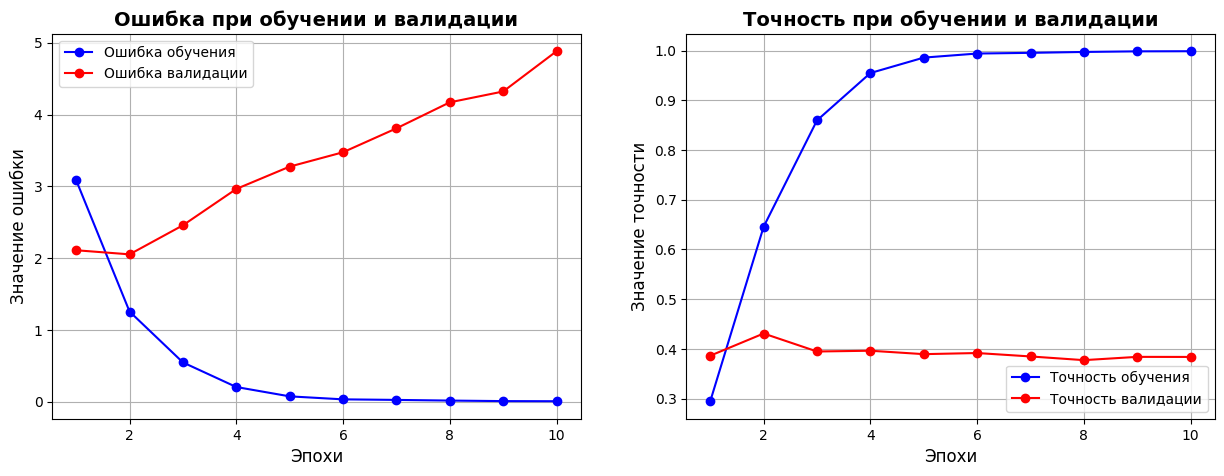

In [87]:
# графики для визуализации процесса обучения
plot_training_curves(hist)

**Вывод**: по графикам процесса обучения видно, что модель переобучается, так как ошибка при обучении стремится к 0, а на данных для валидации увеличиваются, аналогично с графиком точности.

In [119]:
y_predicted_prob = model.predict(test_images) # обучения модели на тестовом наборе
y_predicted = tf.argmax(y_predicted_prob, axis=1)

8/8 [==============================] - 2s 250ms/step


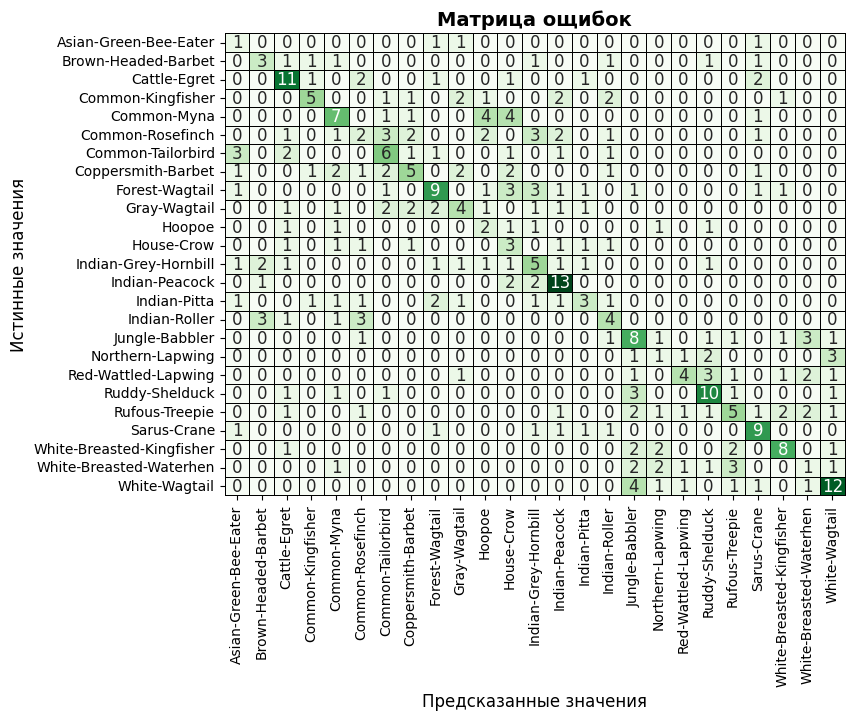

In [120]:
plot_confusion_matrix(
    test_df["encoded_labels"],
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [121]:
model_1_performance = generate_preformance_scores(test_df["encoded_labels"],
                                                          y_predicted,
                                                          y_predicted_prob)

accuracy_score:		0.3760
precision_score:	0.3840
recall_score:		0.3760
f1_score:		0.3726


Попробуем немного увеличить модель и добавить в нее слой dropout и слой GlobalMaxPooling2D

### Вторая модель

In [88]:
# создаем модель нейронной сети
model2 = keras.Sequential([
    keras.Input(shape=(180, 180, 3)), # объявляем размер входных данных
    layers.Rescaling(1./255), # нормализуем данные (делим на 255 чтобы все значения были в диапазоне от 0 до 1)
    layers.Conv2D(32, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.2),
    layers.MaxPooling2D(2, 2), # слой пулинга
    layers.Conv2D(64, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.2),
    layers.GlobalMaxPooling2D(), # слой пулинга
    layers.Flatten(), # выравнивающий слой
    layers.Dense(25, activation="softmax") # выходяной слой с 25 нейронами так как задача многоклассовой классификации (25 классов), активационная функция sigmoid
])

In [89]:
model2.summary() # информация о модели

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 87, 87, 64)        0         
                                                      

In [90]:
model2.compile(loss="categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="rmsprop")

hist2 = model2.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
)

Epoch 1/10
600/600 [==============================] - 307s 507ms/step - loss: 2.4269 - accuracy: 0.2585 - val_loss: 2.0929 - val_accuracy: 0.4121
Epoch 2/10
600/600 [==============================] - 290s 483ms/step - loss: 1.8025 - accuracy: 0.4494 - val_loss: 1.7980 - val_accuracy: 0.4810
Epoch 3/10
600/600 [==============================] - 290s 483ms/step - loss: 1.5556 - accuracy: 0.5247 - val_loss: 1.6041 - val_accuracy: 0.5565
Epoch 4/10
600/600 [==============================] - 320s 533ms/step - loss: 1.3949 - accuracy: 0.5754 - val_loss: 1.5199 - val_accuracy: 0.5667
Epoch 5/10
600/600 [==============================] - 292s 487ms/step - loss: 1.2860 - accuracy: 0.6102 - val_loss: 1.3770 - val_accuracy: 0.6227
Epoch 6/10
600/600 [==============================] - 287s 479ms/step - loss: 1.1979 - accuracy: 0.6350 - val_loss: 1.3203 - val_accuracy: 0.6299
Epoch 7/10
600/600 [==============================] - 322s 537ms/step - loss: 1.1309 - accuracy: 0.6583 - val_loss: 1.2329 -

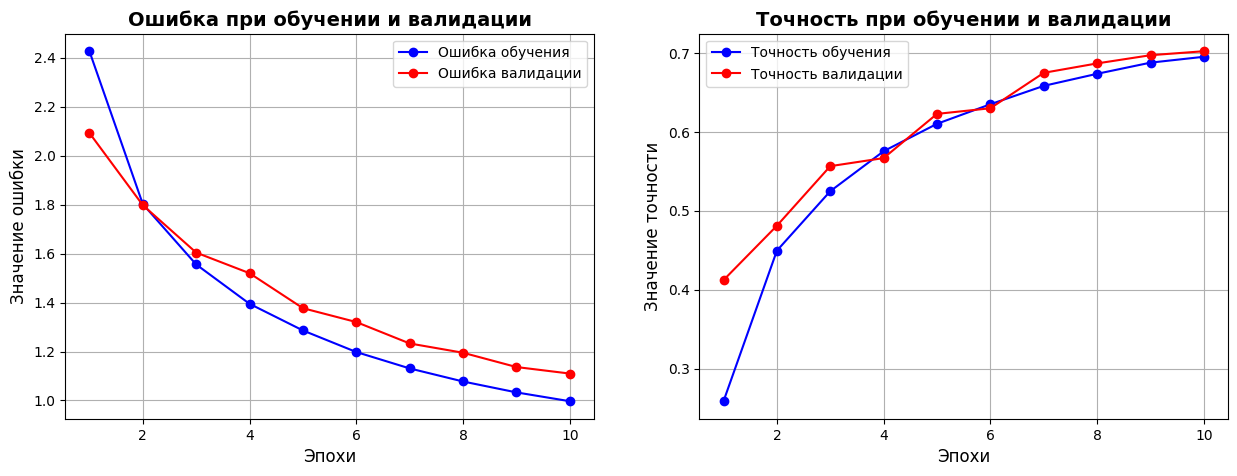

In [91]:
# графики для визуализации процесса обучения
plot_training_curves(hist2)

**Вывод**: видно что обучение проходит хорошо, но можно попробовать углубить сеть так как точность даже на обучении около 70%.

In [92]:
y_predicted_prob = model2.predict(test_images) # обучения модели на тестовом наборе
y_predicted = tf.argmax(y_predicted_prob, axis=1)

8/8 [==============================] - 2s 275ms/step


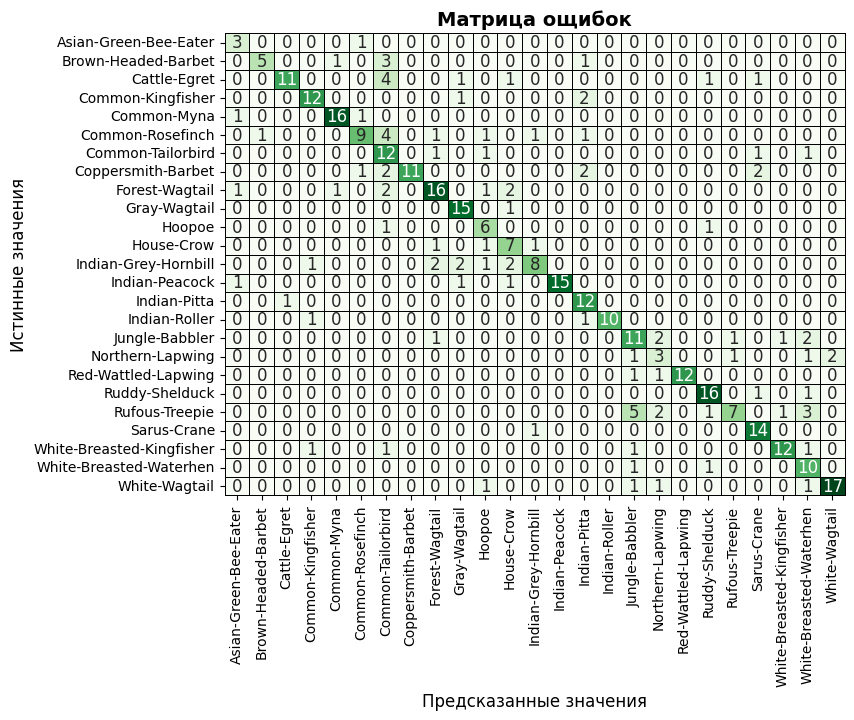

In [93]:
plot_confusion_matrix(
    test_df["encoded_labels"],
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [94]:
model_2_performance = generate_preformance_scores(test_df["encoded_labels"],
                                                          y_predicted,
                                                          y_predicted_prob)

accuracy_score:		0.7200
precision_score:	0.7634
recall_score:		0.7200
f1_score:		0.7227


Попробуем углубить сеть: добавить сверточных и пулинговых слоев

### Третья модель

In [106]:
# создаем модель нейронной сети
model3 = keras.Sequential([
    keras.Input(shape=(180, 180, 3)), # объявляем размер входных данных
    layers.Rescaling(1./255), # нормализуем данные (делим на 255 чтобы все значения были в диапазоне от 0 до 1)
    layers.Conv2D(32, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.2),
    layers.MaxPooling2D(2, 2), # слой пулинга
    layers.Conv2D(64, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.3),
    layers.MaxPooling2D(2, 2), # слой пулинга
    layers.Conv2D(256, (3, 3), activation="relu"), # слой сверточной нейронной сети
    layers.Dropout(0.4),
    layers.GlobalMaxPooling2D(), # слой пулинга
    layers.Flatten(), # выравнивающий слой
    layers.Dense(25, activation="softmax") # выходяной слой с 25 нейронами так как задача многоклассовой классификации (25 классов), активационная функция sigmoid
])

In [96]:
model3.summary() # информация о модели

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_3 (Dropout)         (None, 87, 87, 64)        0         
                                                      

In [97]:
model3.compile(loss="categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="rmsprop")

hist3 = model3.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
)

Epoch 1/10
600/600 [==============================] - 316s 514ms/step - loss: 2.1036 - accuracy: 0.3483 - val_loss: 2.0027 - val_accuracy: 0.5273
Epoch 2/10
600/600 [==============================] - 301s 501ms/step - loss: 1.2596 - accuracy: 0.6164 - val_loss: 1.4870 - val_accuracy: 0.6768
Epoch 3/10
600/600 [==============================] - 304s 506ms/step - loss: 0.9594 - accuracy: 0.7091 - val_loss: 1.2676 - val_accuracy: 0.7316
Epoch 4/10
600/600 [==============================] - 298s 497ms/step - loss: 0.7975 - accuracy: 0.7567 - val_loss: 1.1117 - val_accuracy: 0.7749
Epoch 5/10
600/600 [==============================] - 304s 507ms/step - loss: 0.6816 - accuracy: 0.7915 - val_loss: 0.9558 - val_accuracy: 0.7869
Epoch 6/10
600/600 [==============================] - 298s 496ms/step - loss: 0.6001 - accuracy: 0.8172 - val_loss: 0.8970 - val_accuracy: 0.8275
Epoch 7/10
600/600 [==============================] - 299s 499ms/step - loss: 0.5348 - accuracy: 0.8366 - val_loss: 0.7808 -

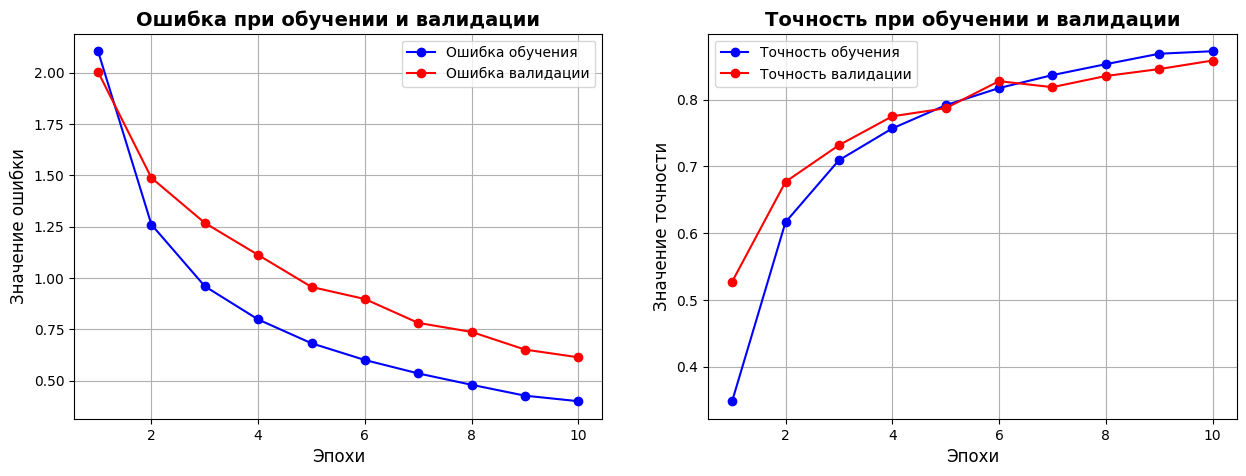

In [101]:
# графики для визуализации процесса обучения
plot_training_curves(hist3)

In [102]:
y_predicted_prob = model3.predict(test_images) # обучения модели на тестовом наборе
y_predicted = tf.argmax(y_predicted_prob, axis=1)

8/8 [==============================] - 3s 310ms/step


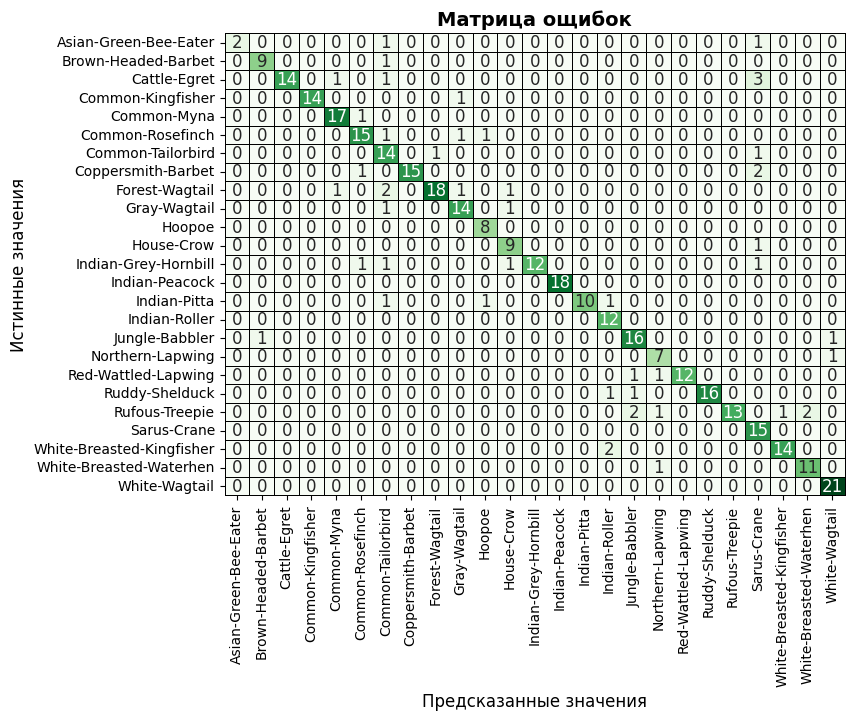

In [103]:
plot_confusion_matrix(
    test_df["encoded_labels"],
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [104]:
model_3_performance = generate_preformance_scores(test_df["encoded_labels"],
                                                          y_predicted,
                                                          y_predicted_prob)

accuracy_score:		0.8693
precision_score:	0.8943
recall_score:		0.8693
f1_score:		0.8715


Попробуем увеличить количество эпох обучения, а таке поменять оптимизатор

### Четвертая модель

In [107]:
model3.compile(loss="categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="adam")

hist4 = model3.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
)

Epoch 1/15
600/600 [==============================] - 338s 557ms/step - loss: 2.0401 - accuracy: 0.3734 - val_loss: 1.8324 - val_accuracy: 0.5865
Epoch 2/15
600/600 [==============================] - 309s 515ms/step - loss: 1.1108 - accuracy: 0.6655 - val_loss: 1.3815 - val_accuracy: 0.7437
Epoch 3/15
600/600 [==============================] - 302s 504ms/step - loss: 0.8608 - accuracy: 0.7408 - val_loss: 1.2295 - val_accuracy: 0.7724
Epoch 4/15
600/600 [==============================] - 302s 503ms/step - loss: 0.7225 - accuracy: 0.7814 - val_loss: 1.0560 - val_accuracy: 0.7969
Epoch 5/15
600/600 [==============================] - 298s 497ms/step - loss: 0.6271 - accuracy: 0.8102 - val_loss: 1.0290 - val_accuracy: 0.7964
Epoch 6/15
600/600 [==============================] - 300s 500ms/step - loss: 0.5659 - accuracy: 0.8273 - val_loss: 0.8962 - val_accuracy: 0.8204
Epoch 7/15
600/600 [==============================] - 301s 501ms/step - loss: 0.5032 - accuracy: 0.8447 - val_loss: 0.8278 -

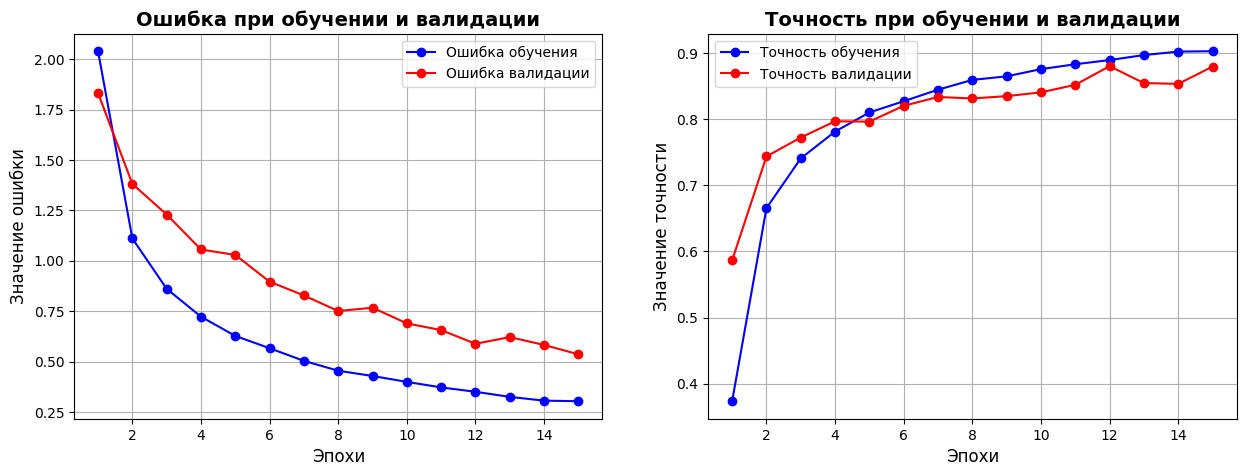

In [108]:
# графики для визуализации процесса обучения
plot_training_curves(hist4)

In [109]:
y_predicted_prob = model3.predict(test_images) # обучения модели на тестовом наборе
y_predicted = tf.argmax(y_predicted_prob, axis=1)

8/8 [==============================] - 3s 284ms/step


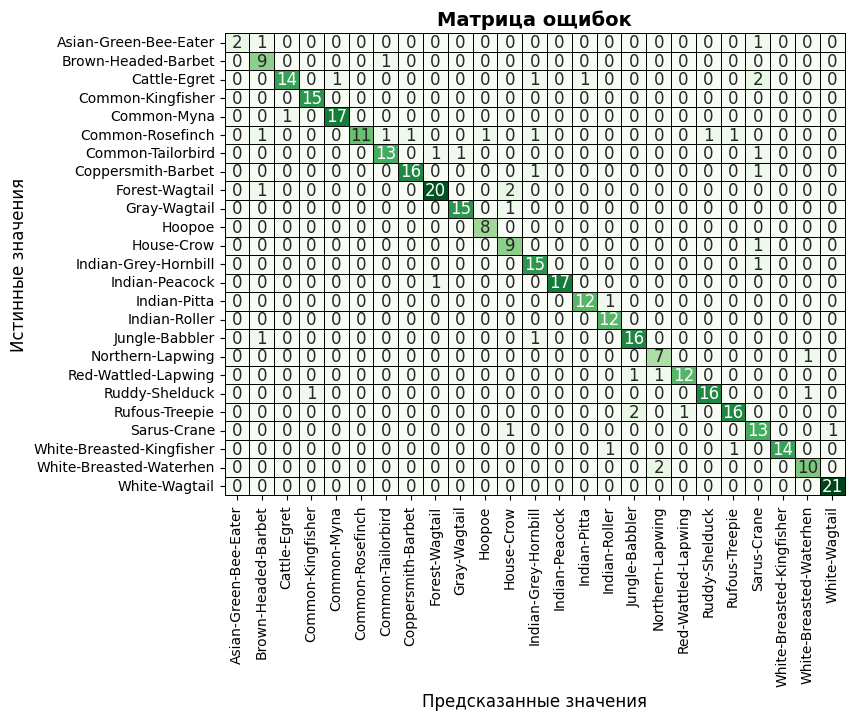

In [110]:
plot_confusion_matrix(
    test_df["encoded_labels"],
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [111]:
model_4_performance = generate_preformance_scores(test_df["encoded_labels"],
                                                          y_predicted,
                                                          y_predicted_prob)

accuracy_score:		0.8800
precision_score:	0.8925
recall_score:		0.8800
f1_score:		0.8799


In [122]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'model_1': model_1_performance,
    'model_2': model_2_performance,
    'model_3': model_3_performance,
    'model_4': model_4_performance
}).T

performance_df

,accuracy_score,precision_score,recall_score,f1_score
model_1,0.376000,0.383988,0.376000,0.372625
model_2,0.720000,0.763398,0.720000,0.722694
model_3,0.869333,0.894257,0.869333,0.871538
model_4,0.880000,0.892517,0.880000,0.879936


Можно сделать вывод, что модель 3, которая является более глубокой и имеет слоли для регуляризации переобучения работает лучше всего, но если изменить оптимизатор на адам (модель 4) значением точности увеличивается с 86.9% до 88%.

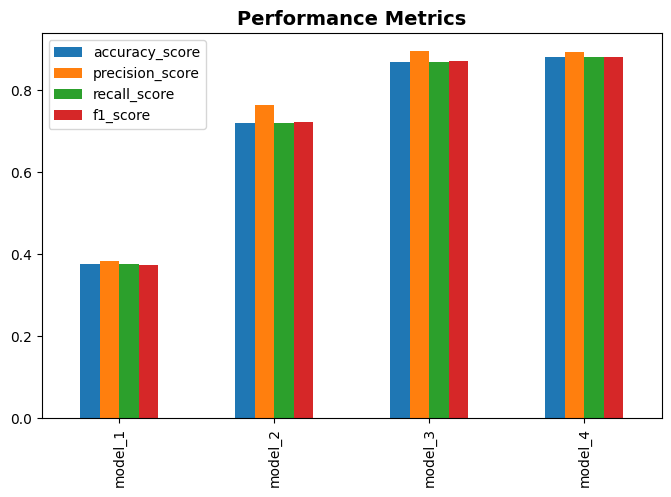

In [126]:
performance_df.plot(kind="bar", figsize=(8, 5))
plt.title('Performance Metrics', fontsize=14, fontweight="bold");
plt.legend()